<a href="https://colab.research.google.com/github/saridango/ncf-music-rec/blob/main/music_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Song Recommendation System

- Inspiration: Spotify's AI playlist curation: DJ, Daylist
- Neural Collaborative Filtering (NCF) Model
- Objective: Recommend new songs based on user's listening history.
- Evaluate several song audio features and user interaction rating



## Dataset Overview
Million Song Subset (extracted from the [Million Song Dataset](http://millionsongdataset.com/pages/getting-dataset/))

- Contains metadata for 10,000 songs from various artists and releases
- includes song-specific audio attributes and popularity metrics

## Purpose of the Dataset
This dataset serves as the foundational input for building and evaluating a song recommendation system. Key use cases include:

- Model Training:
Train a deep learning model to predict user preferences based on song attributes.

- Audio Analysis:
Use audio features (e.g., tempo, key, mode, loudness) to cluster or classify songs.

- Recommendation:
Generate personalized song recommendations by predicting a user’s rating for unseen songs.

In [ ]:
!pip install pandas numpy scikit-learn tensorflow matplotlib


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


## Preprocess Million Song Subset

- extract_h5_data: Extracts features like song_id, artist_name, title, release, and audio features: tempo, loudness, key, mode, duration, and year.

- process_h5_directory: Processes all .h5 files to gather these features into a unified dataset

- clean_and_normalize_data: Cleans missing values and normalizes numerical features like tempo, loudness, and duration to make the data suitable for deep learning, avoiding bias from feature scale differences.

Workflow: Now we have essential features extracted into msd_preprocessed.csv for training a recommendation model that predicts user ratings based on both metadata and audio characteristics.

In [ ]:
import h5py
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import h5py

def extract_h5_data(file_path):
    """
    Extract relevant data from a single .h5 file, handling the absence of 'track_id'.
    Use 'song_id' as a fallback identifier.
    """
    try:
        with h5py.File(file_path, 'r') as f:
            data = {}

            # Extract metadata/songs
            if '/metadata/songs' in f:
                metadata = f['/metadata/songs'][0]
                # Use 'song_id' instead of 'track_id'
                data['song_id'] = metadata['song_id'].decode('utf-8') if 'song_id' in metadata.dtype.names else None
                data['artist_name'] = metadata['artist_name'].decode('utf-8') if 'artist_name' in metadata.dtype.names else None
                data['title'] = metadata['title'].decode('utf-8') if 'title' in metadata.dtype.names else None
                data['release'] = metadata['release'].decode('utf-8') if 'release' in metadata.dtype.names else None
                data['song_hotttnesss'] = metadata['song_hotttnesss'] if 'song_hotttnesss' in metadata.dtype.names else None

            # Extract analysis/songs
            if '/analysis/songs' in f:
                analysis = f['/analysis/songs'][0]
                data['tempo'] = analysis['tempo'] if 'tempo' in analysis.dtype.names else None
                data['loudness'] = analysis['loudness'] if 'loudness' in analysis.dtype.names else None
                data['key'] = analysis['key'] if 'key' in analysis.dtype.names else None
                data['mode'] = analysis['mode'] if 'mode' in analysis.dtype.names else None
                data['duration'] = analysis['duration'] if 'duration' in analysis.dtype.names else None

            # Extract musicbrainz/songs
            if '/musicbrainz/songs' in f:
                musicbrainz = f['/musicbrainz/songs'][0]
                data['year'] = musicbrainz['year'] if 'year' in musicbrainz.dtype.names else None

            return data

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None



def process_h5_directory(directory):
    """
    Recursively process all .h5 files in the specified directory and extract data.
    Skips files with errors and provides a DataFrame of extracted data.
    """
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.h5'):
                file_path = os.path.join(root, file)
                extracted_data = extract_h5_data(file_path)
                if extracted_data is not None:
                    data.append(extracted_data)
    return pd.DataFrame(data)


def clean_and_normalize_data(df):
    """
    Clean and normalize the dataset.
    - Handle missing values by filling with median.
    - Normalize numerical features using MinMaxScaler.
    """
    # Handle missing values
    df = df.fillna(df.median(numeric_only=True))

    # Normalize numerical features
    numerical_features = ['tempo', 'loudness', 'duration', 'key', 'mode', 'year']
    for feature in numerical_features:
        if feature in df.columns:
            scaler = MinMaxScaler()
            df[feature] = scaler.fit_transform(df[[feature]])

    return df


# Process the .h5 files in the Million Song Subset directory
directory_path = 'data/MillionSongSubset'
msd_data = process_h5_directory(directory_path)

# Clean and normalize the extracted data
if not msd_data.empty:
    cleaned_data = clean_and_normalize_data(msd_data)

    # Save the cleaned data to a CSV file
    cleaned_data.to_csv('msd_preprocessed.csv', index=False)
    print("Preprocessed data saved to 'msd_preprocessed.csv'")
else:
    print("No data extracted. Check the directory or file structure.")


No data extracted. Check the directory or file structure.


## Simulating User Interaction Data
Enhanced the preprocessed data with synthetic user interaction data simulated to mimic real-world user preferences.

This involved assigning plausible ratings to songs based on their features (e.g., tempo, loudness, key, mode). By integrating these simulated interactions with the preprocessed MSD data, the model was trained to predict user preferences and generate personalized recommendations, even in the absence of real interaction data.

In [ ]:
import pandas as pd
import numpy as np

# Load your preprocessed dataset
songs = pd.read_csv('msd_preprocessed.csv')

# Generate synthetic users
num_users = 100
user_ids = [f'user_{i}' for i in range(1, num_users + 1)]

# Simulate user preferences
user_preferences = {
    user: {
        'preferred_tempo': np.random.uniform(0.1, 0.7),  # Wider range
        'preferred_loudness': np.random.uniform(0.5, 1.0)  # Wider range
    }
    for user in user_ids
}

# Assign ratings
ratings = []
for user, prefs in user_preferences.items():
    user_bias = np.random.uniform(-0.5, 0.5)  # User-specific bias
    sampled_songs = songs.sample(50)  # Each user rates 50 songs
    for _, song in sampled_songs.iterrows():
        rating = 5 - 2 * abs(prefs['preferred_tempo'] - song['tempo']) - 2 * abs(prefs['preferred_loudness'] - song['loudness']) + user_bias
        rating = max(1, min(5, rating + np.random.normal(0, 1)))  # Add more noise
        ratings.append({'user_id': user, 'song_id': song['song_id'], 'rating': rating})

# Create a DataFrame
ratings_df = pd.DataFrame(ratings)
ratings_df.to_csv('user_ratings_diversified.csv', index=False)


## Combining Preprocessed Data with Synthetic User Interaction Data

In [ ]:
import pandas as pd

# Load the preprocessed MSD dataset
msd_preprocessed = pd.read_csv('msd_preprocessed.csv')

# Load the synthetic ratings dataset
synthetic_ratings = pd.read_csv('user_ratings_diversified.csv')

# Join the datasets on 'song_id'
# Ensure both datasets have 'song_id' column
combined_data = pd.merge(synthetic_ratings, msd_preprocessed, on='song_id', how='inner')

# Save the combined dataset to a new CSV file
combined_data.to_csv('combined_msd_with_ratings.csv', index=False)

print("Datasets successfully combined and saved to 'combined_msd_with_ratings.csv'")


Datasets successfully combined and saved to 'combined_msd_with_ratings.csv'


## Data Loading and More Preprocessing

We load the interaction dataset and encode the user and song IDs for compatibility with the deep learning model.


In [ ]:
# Load dataset
data = pd.read_csv('combined_msd_with_ratings.csv')

# Encode user_id and song_id as integers
data['user_id'] = data['user_id'].astype('category').cat.codes
data['song_id'] = data['song_id'].astype('category').cat.codes

# Define input features and target
X = data[['user_id', 'song_id', 'tempo', 'loudness', 'key', 'mode', 'duration']]
y = data['rating']

# Scale ratings to 0–1 for training
y_scaled = (y - 1) / 4  # Scale 1–5 ratings to 0–1

## Data Splitting

Split the data into training and testing sets for model evaluation.


In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)


## Type of Model:

### Neural Collaborative Filtering (NCF) model

- Collaborative Filtering approach leverages the interaction between user ratings and songs to make predictions about a user's prefernece for songs they haven't interacted with yet
- Learns complex patterns between users and items
- Incorporates audio features (tempo, loudness, key, etc) to enable more naunced recommendations based on both user preferences and song chracteristics




## Why this model?
Ideal for music recommendation
- Combines collaborative filtering (user-song interaction) and content-based filtering (song features)



## Model Architecture

## 1. Prediction Phase

Goal: The model learns to predict user-song ratings based on user, song, and audio features.

Inputs:

- user_id (mapped as user_idx).
- song_id (mapped as song_idx).
- audio features (e.g., tempo, loudness, key, mode, duration).

Output: The model predicts a rating (predicted_rating) for each user-song pair during training.





In [ ]:
# Number of unique users and songs
num_users = data['user_id'].nunique()
num_songs = data['song_id'].nunique()

# Dynamic embedding size
embedding_size = int((num_users + num_songs) ** 0.25)

# Define input layers
user_input = Input(shape=(1,), name='user_input')
song_input = Input(shape=(1,), name='song_input')
audio_input = Input(shape=(5,), name='audio_input')  # 5 audio features: tempo, loudness, key, mode, duration

# Embedding layers for users and songs with L2 regularization
user_embedding = Embedding(num_users, embedding_size, name='user_embedding',
                           embeddings_regularizer=l2(0.01))(user_input)
song_embedding = Embedding(num_songs, embedding_size, name='song_embedding',
                           embeddings_regularizer=l2(0.01))(song_input)

# Flatten embeddings
user_vec = Flatten(name='user_flatten')(user_embedding)
song_vec = Flatten(name='song_flatten')(song_embedding)

# Concatenate embeddings and audio features
concat = Concatenate()([user_vec, song_vec, audio_input])

# Fully connected layers
fc1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(concat)
fc1 = BatchNormalization()(fc1)
dropout1 = Dropout(0.5)(fc1)

fc2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout1)
fc2 = BatchNormalization()(fc2)
dropout2 = Dropout(0.5)(fc2)

# Output layer with sigmoid activation
output = Dense(1, activation='sigmoid', name='rating_output')(dropout2)
scaled_output = output * 4 + 1  # Scale sigmoid output to 1-5

# Define the model
model = Model(inputs=[user_input, song_input, audio_input], outputs=output)

# Compile the model with Mean Squared Error loss and Mean Absolute Error metric
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=[MeanAbsoluteError()])

model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ song_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 7)           │            700 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ song_embedding            │ (None, 1, 7)           │         27,559 │ song_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_flatten (Flatten)    │ (None, 7)              │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ song_flatten (Flatten)    │ (None, 7)              │              0 │ song_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio_input (InputLayer)  │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 19)             │              0 │ user_flatten[0][0],    │
│ (Concatenate)             │                        │                │ song_flatten[0][0],    │
│                           │                        │                │ audio_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 128)            │          2,560 │ concatenate_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 128)            │            512 │ dense_34[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 128)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 64)             │          8,256 │ dropout_34[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 64)             │            256 │ dense_35[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_35 (Dropout)      │ (None, 64)             │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_output (Dense)     │ (None, 1)              │             65 │ dropout_35[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,908 (155.89 KB)

 Trainable params: 39,524 (154.39 KB)

 Non-trainable params: 384 (1.50 KB)

**Input Layers:** user IDs, song IDs, and audio features (tempo, loudness, key, mode, duration)

**Embedding Layers:** Maps user and song IDs to dense vectors of size embedding_size - represents relationships between users and songs

**Flatten Layers:** Converts the user and song embeddings into 1D vectors for further processing and concatenation.

**Concatenation Layer:** Combines user embeddings, song embeddings, and audio features into a unified vector for processing relationships and preferences holistically.

**First Dense Layer:** 128 neurons with ReLU activation to learn complex patterns from the combined input features.

**Second Dense Layer:** 64 neurons with ReLU activation for further refinement of patterns learned in the first layer.

**Dropout:** Drops 50% of neurons - prevent overfitting and improve generalization

**Output Layer:** Predict user rating as a continuous value.

**Optimizer:** Adam optimizer for adaptive learning rates and robustness to noisy data.

**Loss Function:** Mean Squared Error (MSE) for measuring the difference between predicted and actual ratings in regression tasks.

**Metrics:** Mean Absolute Error (MAE) for an intuitive measure of average prediction error.

## Hyperparameter Tuning
Problem: Overconfidence in reccomendation scores

Applied regulatization:
- increased dropout rates from 30% to 50%: prevent overfitting, prevents model from memorizing specific features, better generalization to new data
- added weight decay to optimizer: adds penalty to loss function based on size of model's weights to discourage excessively large weights during training, prevent overrating songs as "very good"

## Model Training

Goal: The model adjusts its weights to minimize the difference between predicted_rating and actual_rating using the Mean Squared Error (MSE) loss function.


In [ ]:
# Separate inputs for training
train_user = X_train['user_id']
train_song = X_train['song_id']
train_audio = X_train[['tempo', 'loudness', 'key', 'mode', 'duration']]

# Separate inputs for testing
test_user = X_test['user_id']
test_song = X_test['song_id']
test_audio = X_test[['tempo', 'loudness', 'key', 'mode', 'duration']]

# Train the model
history = model.fit(
    [train_user, train_song, train_audio],
    y_train,  # Scaled ratings (0–1)
    validation_data=([test_user, test_song, test_audio], y_test),
    batch_size=64,
    epochs=20,
    verbose=1
)

# Save the trained model
model.save('song_recommendation_model_fixed.keras')
print("Model saved to song_recommendation_model_fixed.keras")


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.1827 - mean_absolute_error: 0.3470 - val_loss: 0.5201 - val_mean_absolute_error: 0.2015
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4639 - mean_absolute_error: 0.2787 - val_loss: 0.2264 - val_mean_absolute_error: 0.1727
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2115 - mean_absolute_error: 0.2300 - val_loss: 0.1132 - val_mean_absolute_error: 0.1668
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1151 - mean_absolute_error: 0.2144 - val_loss: 0.0681 - val_mean_absolute_error: 0.1651
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0728 - mean_absolute_error: 0.2018 - val_loss: 0.0480 - val_mean_absolute_error: 0.1651
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0536 - mean_absolute_error: 0.1923 - val_loss: 0.0377 - val_mean_absolute_error: 0.1653
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0408 - mean_absolute_error: 0.1814 - val_loss: 0.031

## Model Evaluation

Goal: Compare the predicted ratings (predicted_rating) with the actual ratings (y_test) to evaluate performance.

Metrics Used:

- Mean Absolute Error (MAE): Measures the average absolute difference between predicted and actual ratings.

- Loss (MSE): Measures the squared difference between predicted and actual ratings.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0218 - mean_absolute_error: 0.1733 
Test Loss: 0.020697366446256638
Test MAE: 0.1680516004562378


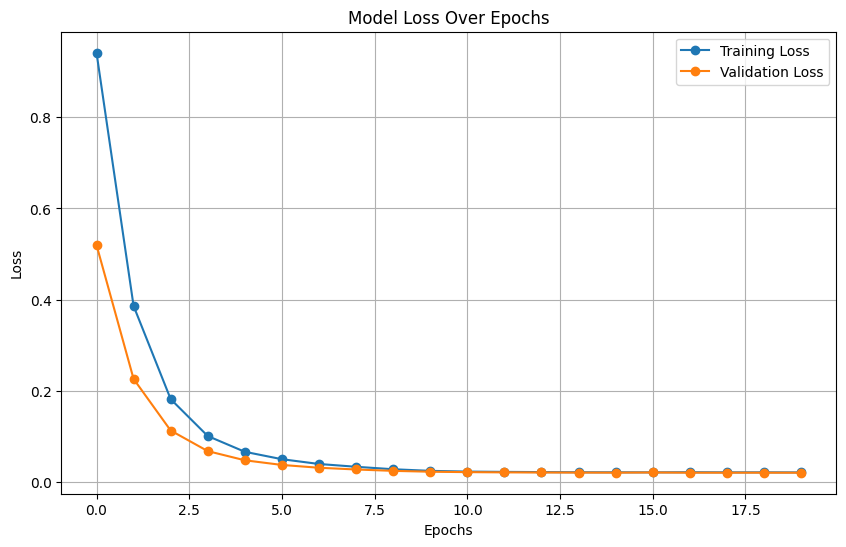

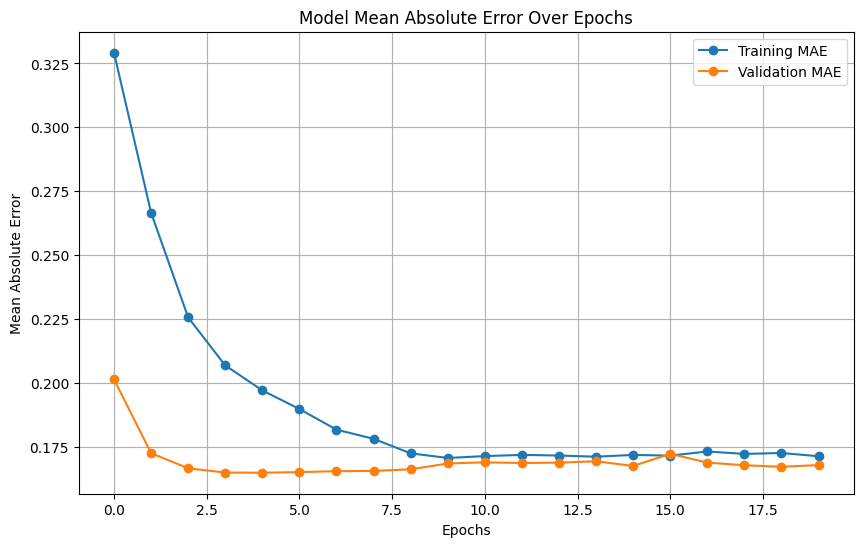

In [ ]:
# Evaluate on the test set
loss, mae = model.evaluate([test_user, test_song, test_audio], y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")

# Plot the training history
def plot_training_history(history):
    # Loss plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Mean Absolute Error plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mean_absolute_error'], label='Training MAE', marker='o')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', marker='o')
    plt.title('Model Mean Absolute Error Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the training and validation metrics
plot_training_history(history)


## Key Observations & Insights

Training and validation loss decrease rapidly
- During early epochs, training and validation loss decline quickly
- Indicates model is learning effectively from data and capturing patterns in dataset
- Fits well without difficulty

Low validation loss
- Strong alignment between model's predictions and actual ratings in validation set
- Generalizing well to unseen data

Training and validation loss converge towards the end
- Model training stabilized
- Balanced between bias and varience



## Generating Recommendations


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model


# Configure Pandas to display all rows and columns
pd.set_option('display.max_rows', 100)  # Show all rows
pd.set_option('display.max_columns', 100)  # Show all columns

# Load the trained model
model = load_model('song_recommendation_model_fixed.keras')
print("Model loaded successfully.")

# Load the original training dataset
dataset_path = "combined_msd_with_ratings.csv"  # Replace with actual path
dataset = pd.read_csv(dataset_path)

print("Loaded dataset:")
print(dataset.head())

# Encode user_id and song_id as integers (same encoding used during training)
user_ids = {user: idx for idx, user in enumerate(dataset['user_id'].unique())}
song_ids = {song: idx for idx, song in enumerate(dataset['song_id'].unique())}

dataset['user_idx'] = dataset['user_id'].map(user_ids)
dataset['song_idx'] = dataset['song_id'].map(song_ids)

# Load user interaction data (top 50 songs)
user_data_path = "user_top_50_songs.csv"  # Replace with actual path
user_data = pd.read_csv(user_data_path)

print("Loaded user interaction data:")
print(user_data.head())

# Map user interaction data to indices
user_data['user_idx'] = user_data['user_id'].map(user_ids)
user_data['song_idx'] = user_data['song_id'].map(song_ids)

# Filter valid songs present in the dataset
valid_songs = dataset[dataset['song_idx'].notna()].copy()
valid_songs = valid_songs.drop_duplicates(subset=['song_id'])

print(f"Total valid songs for querying: {len(valid_songs)}")

# Function to generate recommendations
def recommend_songs(user_id, user_data, valid_songs, model, top_n=10):
    user_idx = user_data.loc[user_data['user_id'] == user_id, 'user_idx'].iloc[0]
    valid_songs['user_idx'] = user_idx

    # Prepare inputs for the model
    user_input = np.array([user_idx] * len(valid_songs))
    song_input = valid_songs['song_idx'].values
    features = valid_songs[['tempo', 'loudness', 'key', 'mode', 'duration']].values

    # Predict ratings and scale back to 1–5 range
    predicted_ratings = model.predict([user_input, song_input, features])
    predicted_ratings = np.clip(predicted_ratings * 4 + 1, 1, 5)  # Scale and clip to 1–5 range
    valid_songs['predicted_rating'] = predicted_ratings

    # Sort and return top recommendations
    recommendations = valid_songs.sort_values(by='predicted_rating', ascending=False).head(top_n)
    return recommendations[['song_id', 'title', 'artist_name', 'predicted_rating']]

# Generate recommendations for the test user
user_to_recommend = 'user_1'
recommendations = recommend_songs(user_to_recommend, user_data, valid_songs, model, top_n=10)

print("Recommendations for User:")
print(recommendations)


Model loaded successfully.
Loaded dataset:
  user_id             song_id    rating                          artist_name  \
0  user_1  SOUIYTT12A8C137D45  4.397447            The Johnny Otis Orchestra   
1  user_1  SOSIVYG12A6D4F93A9  3.985936                               G-Unit   
2  user_1  SOIWLHH12A8C13B9EE  4.420809                    The Cate Brothers   
3  user_1  SOPYMLY12AC3DF67AE  4.635163  Disco D feat. Lola Damone & Helluva   
4  user_1  SOMCTKM12A8C138B86  1.201849                Juan Carlos Baglietto   

                                     title                   release  \
0                                 Cry Baby    Jukebox Hits 1946-1954   
1                      Poppin' Them Thangs              Hot Joints 2   
2                                Radioland                 Radioland   
3  Keys To The Whip (Straight Pimpin' Mix)  A Night At the Booty Bar   
4                        Tiempos Dificiles         Actuar Para Vivir   

   song_hotttnesss     tempo  loudness     

### Room for Improvement:
Reducing overconfidence if any? (ratings too close to 5)
- indicating overfitting or relying to heavily on specific features
1. Huber loss instead of Mean Squared Error (MSE)
- penalize large deviations more gently, making model less overconfident

2. Regularization
- increase dropout rate in the dense layers

3. Data preprocessing
- dataset might be biased towards higher ratings (3-5)
- augment dataset with more diverse user preferences for balanced distribution of ratings (1-5)

4. Additional audio features
- features like danceability, instrumentalness, speechiness, etc. to capture subtle differences to differentiate songs



## Potential Applications & Future Development


### Applications:
- Spotify DJ/Daylist but better?
- Discovery of new and niche tracks encouraging exploration of underground artists

### Future Development
- Spotify API integration and community-based data such as RateYourMusic to curate better recommendations
- New API limitations making scalability more difficult
- otherwise, testing with full music database